In [20]:
import argparse
import copy
from collections import defaultdict
import datetime as dt
import glob
import re
import json
import shutil
import os
import pickle
import yaml
import math
import time
import typing as t
from pathlib import Path
from tqdm.auto import tqdm

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms


In [21]:
from memotr.models import build_model
from memotr.data import build_dataset, build_sampler, build_dataloader
from memotr.models.utils import load_pretrained_model
from memotr.models.criterion import build as build_criterion, ClipCriterion
import torch.distributed

from typing import List, Tuple, Dict
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from memotr.models import build_model
from memotr.data import build_dataset, build_sampler, build_dataloader
from memotr.utils.utils import labels_to_one_hot, is_distributed, distributed_rank, set_seed, is_main_process, \
    distributed_world_size
from memotr.utils.nested_tensor import tensor_list_to_nested_tensor
from memotr.models.memotr import MeMOTR
from memotr.structures.track_instances import TrackInstances
from memotr.models.criterion import build as build_criterion, ClipCriterion
from memotr.models.utils import get_model, save_checkpoint, load_checkpoint
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR
from memotr.log.logger import Logger, ProgressLogger
from memotr.log.log import MetricLog
from memotr.models.utils import load_pretrained_model
import cv2
import time
import os.path
import sys
import numpy as np
from memotr.models import build_model
from memotr.models.utils import load_checkpoint
from memotr.utils.utils import yaml_to_dict

import torch
from typing import List
from memotr.models import build_model
from memotr.models.utils import load_checkpoint, get_model
from memotr.models.runtime_tracker import RuntimeTracker
from memotr.utils.utils import (
    yaml_to_dict,
    is_distributed,
    distributed_world_size,
    distributed_rank,
    inverse_sigmoid,
)
from memotr.utils.nested_tensor import tensor_list_to_nested_tensor
from memotr.utils.box_ops import box_cxcywh_to_xyxy
from memotr.structures.track_instances import TrackInstances

import torchvision.transforms.functional as F

In [22]:
config=yaml.unsafe_load(open('./train_mot17.yaml'))
config

{'ACCUMULATION_STEPS': 1,
 'ACTIVATION': 'ReLU',
 'AUX_LOSS': True,
 'AUX_LOSS_WEIGHT': [1.0, 1.0, 1.0, 1.0, 1.0],
 'AVAILABLE_GPUS': '0,1,2,3,4,5,6,7',
 'BACKBONE': 'resnet50',
 'BATCH_SIZE': 1,
 'CHECKPOINT_LEVEL': 2,
 'CLIP_MAX_NORM': 0.1,
 'COCO_SIZE': True,
 'CONFIG_PATH': './outputs/memotr_mot17/train/config.yaml',
 'DATASET': 'MOT17',
 'DATA_PATH': None,
 'DATA_ROOT': '/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset',
 'DET_SCORE_THRESH': 0.5,
 'DEVICE': 'cuda',
 'DROPOUT': 0.0,
 'EPOCHS': 130,
 'EVAL_DATA_SPLIT': 'val',
 'EVAL_DIR': None,
 'EVAL_MODE': 'specific',
 'EVAL_MODEL': None,
 'EVAL_PORT': None,
 'EVAL_THREADS': 1,
 'EXTRA_TRACK_ATTN': False,
 'FFN_DIM': 2048,
 'FP_INSERT_RATE': 0.0,
 'GIT_VERSION': None,
 'HIDDEN_DIM': 256,
 'LONG_MEMORY_LAMBDA': 0.01,
 'LOSS_WEIGHT_FOCAL': 2,
 'LOSS_WEIGHT_GIOU': 2,
 'LOSS_WEIGHT_L1': 5,
 'LR': 0.0002,
 'LR_BACKBONE': 2e-05,
 'LR_DROP_MILESTONES': [120],
 'LR_DROP_RATE': 0.1,
 'LR_POINTS': 2e

In [23]:
config['DATA_ROOT']='/media/master/t7/msc_studies/pose_estimation/object_pose_tracking/data/MOT17/train_subset'
config["DATASET"]='MOT17'
config["USE_CROWDHUMAN"]=False
# config["NO_GRAD_FRAMES"]

In [24]:
dataset_train = build_dataset(config=config, split="train")
sampler_train = build_sampler(dataset=dataset_train, shuffle=True)
dataloader_train = build_dataloader(dataset=dataset_train, sampler=sampler_train,
                                    batch_size=1, num_workers=0)


In [25]:
len(dataset_train)

599

In [26]:
b=next(iter(dataloader_train))

In [27]:
from pose_tracking.utils.misc import free_cuda_mem


free_cuda_mem()

In [28]:
b["imgs"][0][0].shape, len(b["imgs"]), len(b["imgs"][0])

(torch.Size([3, 1082, 992]), 1, 2)

In [29]:
b.keys()

dict_keys(['imgs', 'infos'])

In [30]:
len(b['infos']),len(b['infos'][0]), b['infos'][0][0].keys()

(1, 2, dict_keys(['boxes', 'ids', 'labels', 'areas', 'dataset', 'unnorm_img']))

In [31]:
from pose_tracking.nb_utils_static import get_exp_args, get_nb_train_exp_tools, create_train_data
from pose_tracking.utils.args_parsing import postprocess_args
exp_name = "tremendous_brad_9416"
args = get_exp_args(exp_name)
logger, exp_tools, device, model_path, writer, world_size, is_main_process, logdir, exp , *_ = (
    get_nb_train_exp_tools(args)
)

args.seq_start = None
args.seq_start = 0
args.seq_len = 4
args.seq_len = 5
args.seq_len = 1
args.seq_len = 3
args.seq_step = 0
args.seq_step = 30
args.seq_step = 1
args.max_train_videos = 10
args.max_train_videos = 16
args.max_train_videos = 4
args.max_train_videos = 1
args.max_train_videos = 2
args.batch_size = args.max_train_videos
args.batch_size = 24
args.batch_size = 16
args.batch_size = 8
args.batch_size = 4
args.batch_size = 1
args.batch_size = 2

args.model_name = "memotr"

args.ds_name="ycbi"
args.ds_name="ikea"


args.do_predict_rel_pose = True
args.do_predict_3d_rot = True
args.do_predict_6d_rot = True
args.do_predict_2d_t = True
args.use_entire_seq_in_train = True
args.do_subtract_bg = True


args.do_predict_rel_pose = False
args.do_predict_3d_rot = False
# args.do_predict_6d_rot = False
args.do_predict_2d_t = False
args.use_entire_seq_in_train = False
args.do_subtract_bg = False

args.ds_folder_name_train = "custom_sim_cube_200"
args.ds_folder_name_val = "custom_sim_cube_200"

num_samples = 4
num_samples = args.batch_size // args.max_train_videos
do_predict_kpts = args.do_predict_kpts
use_priv_decoder = args.use_priv_decoder

args=postprocess_args(args, use_if_provided=False)

train_loader, train_dataset, num_samples, metadata, *_ = create_train_data(
    args, logger, num_samples=num_samples
)

/home/master/.conda/envs/pt/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/mnt/t7/msc_studies/pose_estimation/related_work/kpt_det_match/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
INFO:OpenGL.acceleratesupport:OpenGL_accelerate module loaded
INFO:OpenGL.arrays.arraydatatype:Using accelerated ArrayDatatype


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Overriding with args from exp plastic_grasshopper_4420
Ignoring overriding batch_size
Ignoring overriding device
Ignoring overriding do_predict_3d_rot
Ignoring overriding do_predict_rel_pose
Ignoring overriding exp_disabled
Ignoring overriding exp_name
Ignoring overriding ignored_file_args
Ignoring overriding no_obs_belief
Ignoring overriding transform_names
Ignoring overriding transform_prob
Ignoring overriding use_ddp
Ignoring overriding encoder_img_weights
2025-03-02 18:41:12 | INFO | nb_utils_static.py:724 | CLI command:
python /home/master/.conda/envs/pt/lib/python3.10/site-packages/ipykernel_launcher.py --f=/home/master/.local/share/jupyter/runtime/kernel-v322e38f35a2fb9a50197c192f3f8997b7c8f81c9b.json
2025-03-02 18:41:12 | INFO | common.py:18 | +------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2025-03-02 18:41:12 | INFO | nb_utils_static.py:817 | len(train_dataset)=2
2025-03-02 18:41:12 | INFO | nb_utils_static.py:818 | len(train_loader)=1


In [32]:
args.max_train_videos, args.seq_len, args.ds_name

(2, 3, 'ikea')

In [33]:
batch=next(iter(train_loader))

taking batch_idx=1 of 3
len(seq)=3


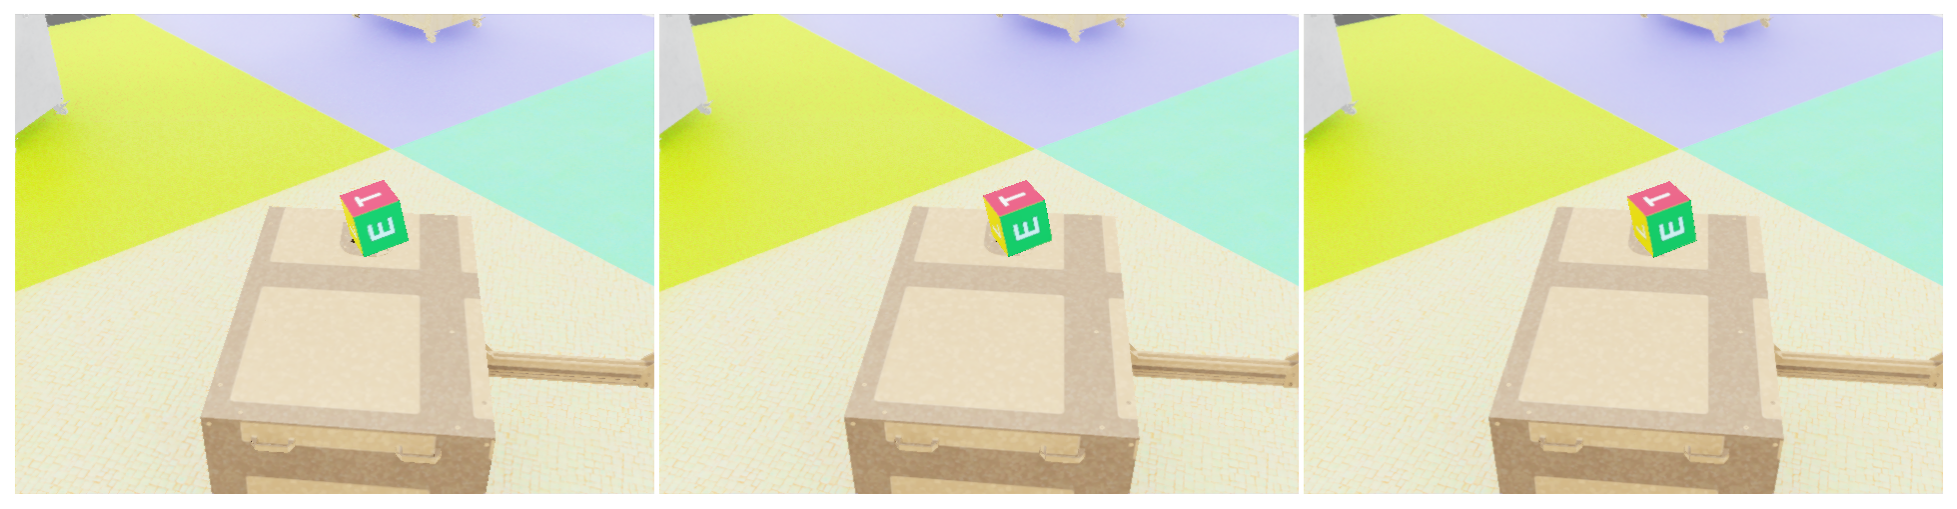

In [34]:
from pose_tracking.dataset.ds_common import convert_batch_seq_to_seq_batch
from pose_tracking.utils.vis import plot_seq

# bbatch_seq=convert_batch_seq_to_seq_batch(bbatch)
# plot_seq(bbatch_seq)
plot_seq(batch, batch_idx=1)

/home/master/.conda/envs/pt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/master/.conda/envs/pt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/5 [00:00<?, ?it/s]

/home/master/.conda/envs/pt/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch=4
hist[-1]=array(1.3812027, dtype=float32)


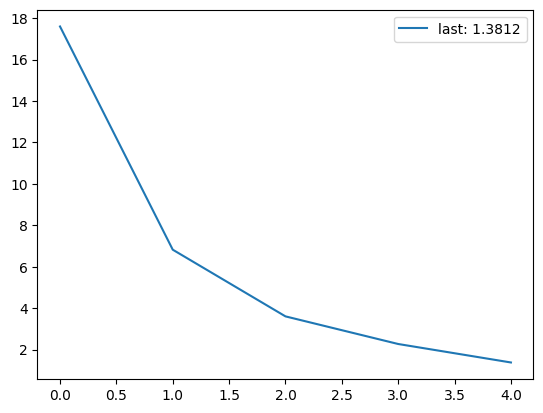

In [ ]:
from memotr.train_engine import get_param_groups
from pose_tracking.utils.common import cast_to_numpy
from pose_tracking.utils.artifact_utils import log_model_meta

config["USE_DAB"] = False
config["BACKBONE"] = "resnet18"
config["BACKBONE"] = "resnet50"
config["rot_out_dim"] = 6
config["t_out_dim"] = 3
config["NUM_DET_QUERIES"] = 1
config["NUM_DEC_LAYERS"] = 2
config["NUM_ENC_LAYERS"] = 2
config["WITH_BOX_REFINE"] = False
config["WITH_BOX_REFINE"] = True
config["opt_only"] = ["labels", "rot", "t"]
assert config["WITH_BOX_REFINE"]
model = build_model(config=config)

criterion = build_criterion(config=config)
criterion.set_device(torch.device("cuda", 0))

for p in model.parameters():
    p.requires_grad = False
    p.requires_grad = True


log_model_meta(model)
model.train()
device = torch.device("cuda", 0)
param_groups, lr_names = get_param_groups(config=config, model=model)
optimizer = AdamW(
    params=param_groups,
    # lr=config["LR"],
    # lr=5e-5,
    lr=1e-4,
    # weight_decay=config["WEIGHT_DECAY"],
)

# batch = b
batch = batch

hist = []
epochs = 100
epochs = 10
epochs = 40
epochs *= 2
epochs *= 2
epochs = 5
# epochs*=2
pbar = tqdm(range(epochs))
for epoch in pbar:
    # for each batch, do below
    tracks = TrackInstances.init_tracks(
        batch=batch,
        hidden_dim=model.hidden_dim,
        num_classes=model.num_classes,
        device=device,
        use_dab=config["USE_DAB"],
        rot_out_dim=config["rot_out_dim"],
        t_out_dim=config["t_out_dim"],
        WITH_BOX_REFINE=config["WITH_BOX_REFINE"],
    )
    criterion.init_a_clip(
        batch=batch,
        hidden_dim=model.hidden_dim,
        num_classes=model.num_classes,
        device=device,
    )
    for frame_idx in tqdm(range(len(batch["image"][0])), disable=True):
        frame = [fs[frame_idx] for fs in batch["image"]]
        for f in frame:
            f.requires_grad_(False)
        frame = tensor_list_to_nested_tensor(tensor_list=frame).to(device)
        res = model(frame=frame, tracks=tracks)
        criterion_res = criterion.process_single_frame(
            model_outputs=res, tracked_instances=tracks, frame_idx=frame_idx
        )
        previous_tracks, new_tracks, unmatched_dets, indices = (
            criterion_res["tracked_instances"],
            criterion_res["new_trackinstances"],
            criterion_res["unmatched_detections"],
            criterion_res["matched_idxs"],
        )
        if frame_idx < len(batch["image"][0]) - 1:
            tracks = model.postprocess_single_frame(
                previous_tracks, new_tracks, unmatched_dets
            )

    loss_dict, log_dict = criterion.get_mean_by_n_gts()
    loss = criterion.get_sum_loss_dict(loss_dict=loss_dict)
    accumulation_steps = 1
    loss = loss / accumulation_steps
    loss.backward()
    max_norm = 0.1
    if (epoch + 1) % accumulation_steps == 0:
        # if max_norm > 0:
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        # else:
        #     pass
        optimizer.step()
        optimizer.zero_grad()

    hist.append(cast_to_numpy(loss))
    pbar.set_description(f"Loss: {loss:.4f}")
    # break

print(f"{epoch=}")
print(f"{hist[-1]=}")
plt.plot(hist)
plt.legend([f"last: {hist[-1]:.4f}"])

len(online_tlwhs)=1
len(online_tlwhs)=1
len(online_tlwhs)=1


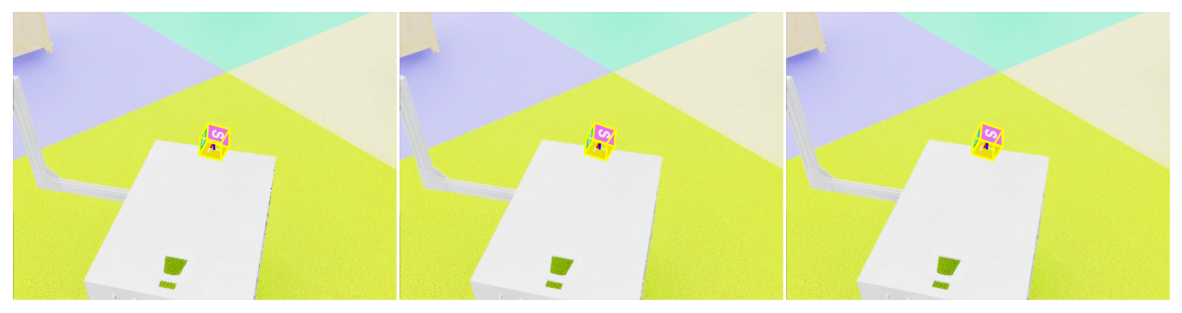

len(online_tlwhs)=1
len(online_tlwhs)=1
len(online_tlwhs)=1


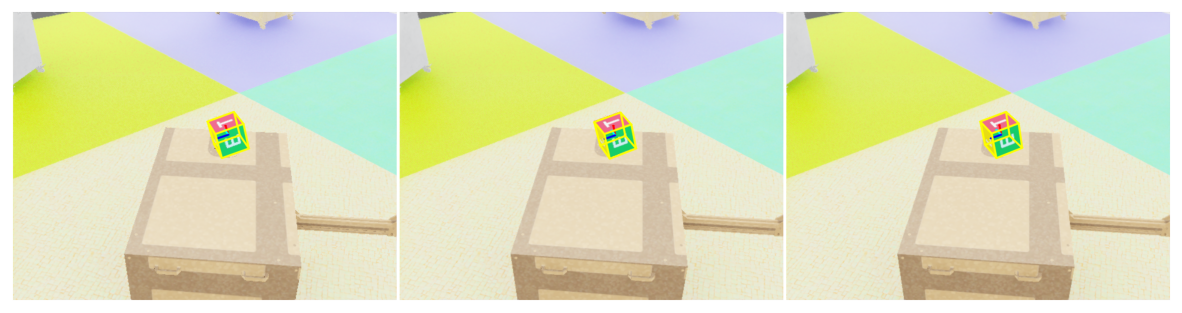

In [ ]:
from memotr.demo import process_image, plot_tracking, Timer
from memotr.submit_engine import filter_by_score, filter_by_area
from pose_tracking.utils.common import adjust_img_for_plt
from pose_tracking.utils.pose import convert_pose_vector_to_matrix
from pose_tracking.utils.vis import make_grid_image, vis_pose

frame_id = 0
model.eval()
height, width = batch["image"].shape[-2:]

result_score_thresh = 0.5
result_area_thresh = 100
det_score_thresh = 0.5
track_score_thresh = 0.5

# track_score_thresh=-1
# det_score_thresh=-1
# result_score_thresh = -1
# result_area_thresh = -1
rot_repr = args.rot_repr
with torch.no_grad():
    for bidx in range(len(batch["image"])):
        tracks = [
            TrackInstances(
                hidden_dim=model.hidden_dim,
                num_classes=model.num_classes,
                use_dab=config["USE_DAB"],
                rot_out_dim=config["rot_out_dim"],
                t_out_dim=config["t_out_dim"],
            ).to("cuda")
        ]
        tracker = RuntimeTracker(
            det_score_thresh=det_score_thresh,
            track_score_thresh=track_score_thresh,
            miss_tolerance=30,
            use_motion=False,
            motion_min_length=0,
            motion_max_length=0,
            visualize=False,
            use_dab=config["USE_DAB"],
        )
        timer = Timer()
        imgs = []
        imgs_bbox = []
        for tidx in range(len(batch["image"][bidx])):
            image = batch["image"][:, tidx]
            frame = tensor_list_to_nested_tensor([image[bidx]]).to("cuda")
            timer.tic()
            res = model(frame=frame, tracks=tracks)
            previous_tracks, new_tracks = tracker.update(
                model_outputs=res, tracks=tracks
            )
            tracks: List[TrackInstances] = model.postprocess_single_frame(
                previous_tracks, new_tracks, None
            )
            timer.toc()

            tracks_result = tracks[0].to(torch.device("cpu"))
            ori_h, ori_w = height, width
            tracks_result.area = (
                tracks_result.boxes[:, 2] * ori_w * tracks_result.boxes[:, 3] * ori_h
            )
            tracks_result = filter_by_score(tracks_result, thresh=result_score_thresh)
            tracks_result = filter_by_area(tracks_result, thresh=result_area_thresh)
            # to xyxy:
            tracks_result.boxes = box_cxcywh_to_xyxy(tracks_result.boxes)
            tracks_result.boxes = tracks_result.boxes * torch.as_tensor(
                [ori_w, ori_h, ori_w, ori_h], dtype=torch.float
            )
            online_tlwhs, online_ids = [], []
            online_rots = []
            online_ts = []
            for i in range(len(tracks_result)):
                x1, y1, x2, y2 = tracks_result.boxes[i].tolist()
                w, h = x2 - x1, y2 - y1
                online_tlwhs.append([x1, y1, w, h])
                online_ids.append(tracks_result.ids[i].item())
                online_rots.append(tracks_result.rots[i])
                online_ts.append(tracks_result.ts[i])
            poses = []
            for i in range(len(online_rots)):
                pose = convert_pose_vector_to_matrix(
                    pose=torch.cat([online_ts[i], online_rots[i]]), rot_repr=rot_repr
                )
                poses.append(pose)
            img_rgb = adjust_img_for_plt(image[bidx])
            print(f"{len(online_tlwhs)=}")
            if len(online_tlwhs) > 0:
                online_im_bbox = plot_tracking(
                    img_rgb,
                    online_tlwhs,
                    online_ids,
                    frame_id=frame_id + 1,
                    fps=1.0 / timer.average_time,
                )
                online_im = copy.deepcopy(img_rgb)
                for pose in poses:
                    online_im = vis_pose(
                        color=online_im,
                        pose=pose,
                        K=batch["target"][bidx][tidx]["intrinsics"],
                        bbox=batch["mesh_bbox"][bidx][tidx],
                    )
            else:
                online_im_bbox = img_rgb
                online_im = img_rgb
            imgs.append(online_im)
            imgs_bbox.append(online_im_bbox)
            frame_id += 1

        # fig = make_grid_image(imgs_bbox)
        fig = make_grid_image(imgs)

In [111]:
tracks

[
 ------------------------------
 self: <class 'memotr.structures.track_instances.TrackInstances'>
 area: tensor([], device='cuda:0')
 boxes: tensor([[0.3631, 0.3783, 0.1193, 0.1193]], device='cuda:0')
 disappear_time: tensor([0], device='cuda:0')
 frame_height: 1.0
 frame_width: 1.0
 hidden_dim: 256
 ids: tensor([0], device='cuda:0')
 iou: tensor([], device='cuda:0')
 labels: tensor([0], device='cuda:0')
 last_appear_boxes: tensor([], device='cuda:0', size=(0, 4))
 last_output: tensor([[ 1.3840, -0.3512, -0.8466,  0.4699,  1.7602, -1.0134, -1.6175,  0.5015,
           0.7524, -0.7792, -1.0470,  0.8611,  0.2057,  0.9435,  1.3868, -0.3455,
           0.1400, -0.1614,  1.2326,  0.7024, -0.7329, -0.2870,  0.4768, -2.5536,
           1.8940, -0.3890,  1.2274, -0.4153,  0.8544, -0.5760, -2.6213,  0.6239,
           0.0652, -0.3869,  0.5325,  0.9263, -0.1314, -0.0676, -0.9948, -1.3675,
          -0.4126, -0.3654,  0.3121,  1.6811, -0.9280,  0.4781,  0.7504,  0.3237,
           0.5866,  0.28

In [26]:
batch['target'][0][tidx]['pose'], pose

(tensor([ 0.1548, -0.0530,  2.7856, -0.7714, -0.1287,  0.6231, -0.2151, -0.8690,
         -0.4457]),
 tensor([[-0.8748,  0.2271,  0.4280, -0.0278],
         [-0.3353, -0.9214, -0.1964, -0.1527],
         [ 0.3497, -0.3153,  0.8822,  2.3787],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]))

In [27]:
from pose_tracking.utils.pose import convert_pose_vector_to_matrix
online_tlwhs, online_ids = [], []
online_rots=[]
online_ts=[]
for i in range(len(tracks_result)):
    x1, y1, x2, y2 = tracks_result.boxes[i].tolist()
    w, h = x2 - x1, y2 - y1
    online_tlwhs.append([x1, y1, w, h])
    online_ids.append(tracks_result.ids[i].item())
    online_rots.append(tracks_result.rots[i])
    online_ts.append(tracks_result.ts[i])
poses = []
for i in range(len(online_rots)):
    pose = convert_pose_vector_to_matrix(pose=torch.cat([online_rots[i], online_ts[i]]), rot_repr=args.rot_repr)
    poses.append(pose)
pose.shape

torch.Size([4, 4])

In [33]:
new_tracks

[
 ------------------------------
 self: <class 'memotr.structures.track_instances.TrackInstances'>
 area: tensor([], device='cuda:0')
 boxes: tensor([[0.6888, 0.1354, 0.0909, 0.1074],
         [0.7192, 0.8621, 0.0868, 0.1057],
         [0.3102, 0.1527, 0.0889, 0.1071],
         [0.7252, 0.5208, 0.0875, 0.1066],
         [0.5632, 0.4711, 0.0769, 0.1039],
         [0.6284, 0.4916, 0.0870, 0.1072],
         [0.7895, 0.7873, 0.0898, 0.1066],
         [0.4115, 0.4273, 0.0853, 0.1058],
         [0.4794, 0.3616, 0.0868, 0.1077],
         [0.1769, 0.2222, 0.0896, 0.1083]], device='cuda:0')
 disappear_time: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
 frame_height: 1.0
 frame_width: 1.0
 hidden_dim: 256
 ids: tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49], device='cuda:0')
 iou: tensor([], device='cuda:0')
 labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
 last_appear_boxes: tensor([], device='cuda:0', size=(0, 4))
 last_output: tensor([[ 0.7186,  0.4693,  1.6045,  

In [46]:
tracks_result.boxes, len(tracks_result)

(tensor([], size=(0, 4)), 0)

In [41]:
tracks_result


------------------------------
self: <class 'memotr.structures.track_instances.TrackInstances'>
area: tensor([])
boxes: tensor([], size=(0, 4))
disappear_time: tensor([], dtype=torch.int64)
frame_height: 1.0
frame_width: 1.0
hidden_dim: 256
ids: tensor([], dtype=torch.int64)
iou: tensor([])
labels: tensor([], dtype=torch.int64)
last_appear_boxes: tensor([], size=(0, 4))
last_output: tensor([], size=(0, 256))
logits: tensor([], size=(0, 1))
long_memory: tensor([], size=(0, 256))
matched_idx: tensor([], dtype=torch.int64)
num_classes: 1
output_embed: tensor([], size=(0, 256))
query_embed: tensor([], size=(0, 512))
ref_pts: tensor([], size=(0, 4))
rot_out_dim: 4
rots: tensor([], size=(0, 6))
scores: tensor([], size=(0, 1))
t_out_dim: 3
ts: tensor([], size=(0, 3))
use_dab: False

------------------------------

In [21]:
log_dict

{'frame0_box_l1_loss': (0.04002675414085388, 1),
 'frame0_box_giou_loss': (0.3678606152534485, 1),
 'frame0_label_focal_loss': (0.48759323358535767, 1),
 'frame0_rot_loss': (0.02900611236691475, 1),
 'frame0_t_loss': (0.00321186357177794, 1),
 'frame1_box_l1_loss': (0.048509858548641205, 1),
 'frame1_box_giou_loss': (0.47859108448028564, 1),
 'frame1_label_focal_loss': (0.49089354276657104, 1),
 'frame1_rot_loss': (0.039988163858652115, 1),
 'frame1_t_loss': (0.0033450559712946415, 1)}

In [26]:
batch['target'][0]

[{'image_id': tensor([68]),
  'track_ids': tensor([0]),
  'boxes': tensor([[0.5703, 0.5198, 0.0688, 0.0979]]),
  'labels': tensor([0]),
  'intrinsics': tensor([[732.9993,   0.0000, 320.0000],
          [  0.0000, 732.9993, 240.0000],
          [  0.0000,   0.0000,   1.0000]], dtype=torch.float64),
  'pose': tensor([ 0.1976,  0.0459,  3.2190, -0.4978,  0.8602, -0.1106, -0.8010, -0.4072,
           0.4388]),
  'size': tensor([480, 640]),
  'prev_image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0.,

In [23]:
batch.keys(), "image" in batch

(dict_keys(['rgb_path', 'mask', 'obj_name', 'mesh_pts', 'mesh_bbox', 'mesh_diameter', 'bbox_2d_kpts', 'bbox_2d_kpts_collinear_idxs', 'image', 'prev_rgb_path', 'target']),
 True)

In [18]:
model.use_dab

False

In [23]:
frame.tensors.shape, tracks[0].frame_height

(torch.Size([1, 3, 640, 1152]), 1.0)

In [26]:
loss_dict

{'box_l1_loss': tensor(0.0993, device='cuda:0', grad_fn=<DivBackward0>),
 'box_giou_loss': tensor(0.7599, device='cuda:0', grad_fn=<DivBackward0>),
 'label_focal_loss': tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>),
 'aux_box_l1_loss': tensor(0.4417, device='cuda:0', grad_fn=<DivBackward0>),
 'aux_box_giou_loss': tensor(3.7987, device='cuda:0', grad_fn=<DivBackward0>),
 'aux_label_focal_loss': tensor(1.8470, device='cuda:0', grad_fn=<DivBackward0>)}

In [11]:
model

MeMOTR(
  (backbone): BackboneWithPE(
    (backbone): Backbone(
      (backbone): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d

In [12]:
print(f"model.parameters={sum(p.numel() for p in model.parameters() if p.requires_grad)}")

model.parameters=50013984
